In [1]:
import pandas as pd
from scipy import stats
import numpy as np

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Set figure parameters
sns.set_style('ticks')
sns.set_context('paper')
# mpl.rcParams['axes.titlesize'] = 8
# mpl.rcParams['axes.labelsize'] = 8
# mpl.rcParams['xtick.labelsize'] = 6
# mpl.rcParams['ytick.labelsize'] = 6

colours = {'DNA': '#fab95b', 
           'LTR': '#665c84', 
           'LINE': '#71a0a5', 
           'RC': '#ED7F35',
           'SINE': '#5E96B5',
           'Other': '#212121'}

useteclasses = ['LTR', 'LINE', 'DNA', 'RC', 'SINE', 'Other']
tepalette=[colours[i] for i in useteclasses]


In [3]:
summary_df = pd.read_csv('../data/danrer11_te_summary.txt', sep='\t')

te_df = summary_df.copy()[['tename', 'tefam', 'teclass', 'copynum', 'medlen', 'meandiv', 'isltr']].drop_duplicates().dropna()
te_df = te_df.loc[~te_df['isltr']]
te_df.loc[te_df['teclass'].isin(['LINE?', 'SINE?']), 'teclass'] = 'Other'
print(te_df)

                tename          tefam teclass  copynum    medlen    meandiv  \
0              L1-2_DR         L1-Tx1    LINE   3179.0  0.000000   7.173071   
1          ERV5_DR_LTR           ERV1     LTR     19.0  0.000000   4.491648   
2        Gypsy106-I_DR          Gypsy     LTR     69.0  0.000550   1.335491   
5         BEL-45_DRe-I            Pao     LTR    134.0  0.000620   4.258690   
7           BEL19-I_DR            Pao     LTR     70.0  0.002315   1.221869   
...                ...            ...     ...      ...       ...        ...   
2215  Harbinger-N23_DR  PIF-Harbinger     DNA   2524.0  0.380940  21.527080   
2216       hAT-N108_DR         hAT-Ac     DNA   2441.0  0.390315  15.533348   
2217       EnSpm-21_DR      CMC-EnSpm     DNA   5561.0  0.399600  22.186274   
2218       DNA-N26B_DR            DNA     DNA   1248.0  0.439580  18.530516   
2219        DNAX-16_DR            DNA     DNA  10365.0  0.444780  17.624729   

      isltr  
0     False  
1     False  
2     Fal

In [17]:
print(len(te_df.loc[(te_df.medlen < 0.05) & (te_df.copynum > 1000)].sort_values('medlen')))

45


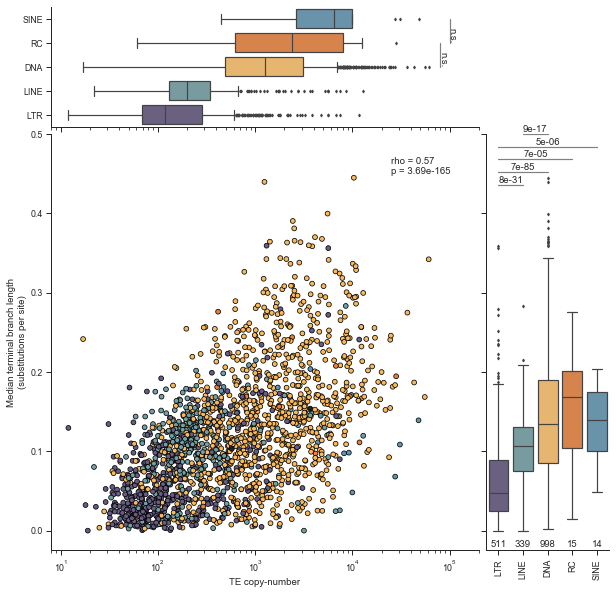

In [4]:
fig = plt.figure(figsize=(10, 10))

spec = gridspec.GridSpec(ncols=13, nrows=13, figure=fig)
ax0 = fig.add_subplot(spec[3:13, :10])
ax1 = fig.add_subplot(spec[3:13:, 10:], sharey=ax0)
ax2 = fig.add_subplot(spec[:3, :10], sharex=ax0)

sns.scatterplot(data=te_df,
                x='copynum',
                y='medlen',
                hue='teclass',
                hue_order=useteclasses,
                palette=tepalette,
                edgecolor='k',
                ax=ax0)

sns.boxplot(data=te_df.loc[te_df['teclass'] != 'Other'], 
               x='teclass', 
               y='medlen',
               order=useteclasses[:-1],
               hue_order=useteclasses[:-1],
               palette=tepalette[:-1],
               fliersize=2,
               ax=ax1)

sns.boxplot(data=te_df.loc[te_df['teclass'] != 'Other'], 
               y='teclass', 
               x='copynum',
               order=useteclasses[:-1][::-1],
               hue_order=useteclasses[:-1][::-1],
               palette=tepalette[:-1][::-1],
               ax=ax2,
               fliersize=2)


corr = stats.spearmanr(te_df.loc[te_df['teclass'] != 'Other']['copynum'], 
                       te_df.loc[te_df['teclass'] != 'Other']['medlen'])
ax0.text(25000, 0.45, f'rho = {corr[0]:.2f}\np = {corr[1]:.2e}')

y = 0.42
for i, tc1 in enumerate(useteclasses[:-1]):
    for j, tc2 in enumerate(useteclasses[:-1]):
        if i >= j:
            continue
        pval = stats.ranksums(te_df.loc[te_df.teclass == tc1, 'medlen'],
                              te_df.loc[te_df.teclass == tc2, 'medlen'])[1]
        if pval <= 0.01/10:
            y += 0.016
            x = (j + i)/2
            ax1.axhline(y, ((i/10)+0.05)*2, ((j/10)+0.05)*2, color='grey')
            ax1.text(x, y+0.003, f'{pval:.0e}', horizontalalignment='center')

x = 80000
y=0
for i, tc1 in enumerate(useteclasses[:-1]):
    for j, tc2 in enumerate(useteclasses[:-1]):
        if i >= j:
            continue
        pval = stats.ranksums(te_df.loc[te_df.teclass == tc1, 'copynum'],
                              te_df.loc[te_df.teclass == tc2, 'copynum'])[1]
        if pval > 0.01/10:
            y = (4-i + 4-j)/2 + 0.4
            ax2.axvline(x, ((i/10)+0.05)*2, ((j/10)+0.05)*2, color='grey')
            ax2.text(x+5000, y, f'n.s.', horizontalalignment='center', rotation=-90)
            x += 20000

            
for i, tc in enumerate(useteclasses[:-1]):
    n = len(te_df.loc[te_df.teclass == tc, 'tename'].to_list())
    ax1.text(i, -0.02, f'{n}', horizontalalignment='center')

ax0.set_xscale('log')
ax0.set_xlim(8, 200000)
ax0.set_ylim(-0.025, 0.5)

ax0.get_legend().set_visible(False)
ax0.set_xlabel('TE copy-number')
ax0.set_ylabel('Median terminal branch length\n(substitutions per site)')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.tick_params(labelleft=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.tick_params(labelbottom=False)

sns.despine()

fig.savefig(fname='/Users/jonwells/Projects/feschottelab/drerio-tes/figs/te_summary.pdf', bbox_inches='tight')
plt.show()


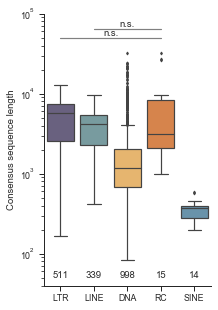

In [5]:
# Compute Wilcoxon rank-sum tests for length diffs between classes

length_df = summary_df[['mergedname', 'tefam', 'teclass', 'length']].copy().drop_duplicates()
length_df = length_df.loc[length_df['teclass'].isin(useteclasses)]

# Generate TE length boxplots
fig, ax = plt.subplots(figsize=(3, 5))
fig = sns.boxplot(data=length_df[length_df['teclass'].isin(useteclasses[:-1])], 
                  x='teclass', 
                  y='length', 
                  order=useteclasses[:-1],
                  hue_order=useteclasses[:-1],
                  palette=tepalette[:-1],
                  fliersize=2,
                  ax=ax)
y = 40000
for i, tc1 in enumerate(useteclasses[:-1]):
    for j, tc2 in enumerate(useteclasses[:-1]):
        if i >= j:
            continue
        pval = stats.ranksums(length_df.loc[length_df.teclass == tc1, 'length'],
                              length_df.loc[length_df.teclass == tc2, 'length'])[1]
        if pval > 0.01/5:
            x = (j + i)/2
            ax.axhline(y, ((i/10)+0.05)*2, ((j/10)+0.05)*2, color='grey')
            ax.text(x, y+3000, f'n.s.', horizontalalignment='center')
        y += 5000

for i, tc in enumerate(useteclasses[:-1]):
    n = len(te_df.loc[te_df.teclass == tc, 'tename'].to_list())
    ax.text(i, 50, f'{n}', horizontalalignment='center')

ax.set_ylim((40, 100000))
ax.set_xlabel('')
ax.set_ylabel('Consensus sequence length')
ax.set_yscale('log')
sns.despine()
plt.show()
ax.figure.savefig('/Users/jonwells/Projects/feschottelab/drerio-tes/figs/te_length.pdf', bbox_inches='tight')


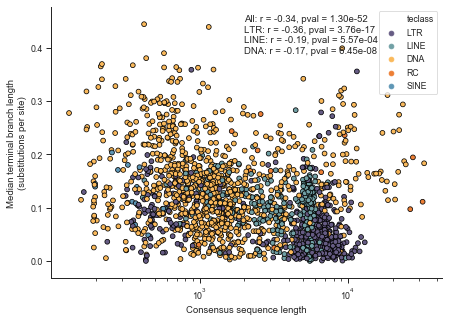

In [6]:
blen_seqlen_df = summary_df[['mergedname', 'tefam', 'teclass', 'length', 'medlen']].copy().drop_duplicates().dropna()

fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=blen_seqlen_df.loc[blen_seqlen_df['teclass'].isin(useteclasses[:-1])], 
                x='length', 
                y='medlen', 
                hue='teclass',
                hue_order=useteclasses[:-1],
                palette=tepalette[:-1],
                edgecolor='k',
                ax=ax)

corr = stats.spearmanr(blen_seqlen_df['length'], blen_seqlen_df['medlen'])
y = 0.45
ax.text(2000, y, f'All: r = {corr[0]:.2f}, pval = {corr[1]:.2e}')
y -= 0.02
for teclass in useteclasses[:-1]:
    corr = stats.spearmanr(blen_seqlen_df.loc[blen_seqlen_df['teclass'] == teclass]['length'], 
                           blen_seqlen_df.loc[blen_seqlen_df['teclass'] == teclass]['medlen'])
    if corr[1] <= 0.01:
        ax.text(2000, y, f"{teclass}: r = {corr[0]:.2f}, pval = {corr[1]:.2e}")
        y -= 0.02

ax.set_xlabel('Consensus sequence length')
ax.set_ylabel('Median terminal branch length\n(substitutions per site)')
ax.set_xscale('log')
sns.despine()
ax.figure.savefig('/Users/jonwells/Projects/feschottelab/drerio-tes/figs/branchlength_seqlength_corr.pdf', bbox_inches='tight')

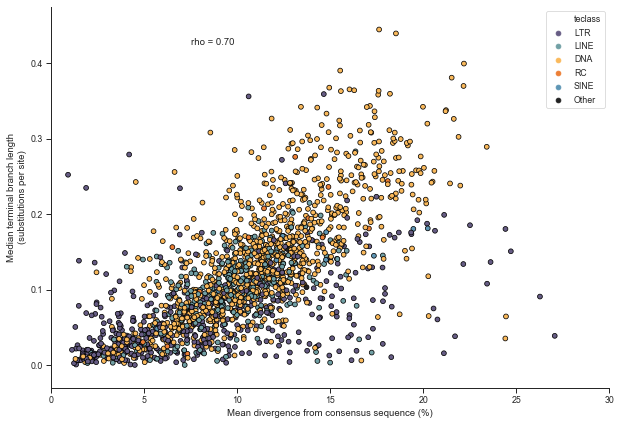

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(data=te_df, 
                x='meandiv', 
                y='medlen', 
                hue='teclass',
                edgecolor='black',
                ax=ax, 
                hue_order=useteclasses,
                palette=tepalette,
                lw=0.1)

corr = stats.spearmanr(te_df['meandiv'], te_df['medlen'])[0]
ax.text(7.5, 0.425, f'rho = {corr:.2f}')

ax.set_xlabel('Mean divergence from consensus sequence (%)')
ax.set_ylabel('Median terminal branch length\n(substitutions per site)')
ax.set_xlim(0, 30)
sns.despine()
fig.savefig('../figs/meandiv_medlen.pdf', bbox_inches='tight')
